In [1]:
import pandas as pd

In [2]:
covid_df_full=pd.read_csv('COVID_ALL.csv')

In [3]:
covid_df_full['Date']=pd.to_datetime(covid_df_full['Date'])


In [4]:
covid_df_full

,Date,Country,Confirmed,Recovered,Deaths,Population
0,2020-01-22,Afghanistan,0.0,0.0,0.0,38928346.0
1,2020-01-23,Afghanistan,0.0,0.0,0.0,38928346.0
2,2020-01-24,Afghanistan,0.0,0.0,0.0,38928346.0
3,2020-01-25,Afghanistan,0.0,0.0,0.0,38928346.0
4,2020-01-26,Afghanistan,0.0,0.0,0.0,38928346.0
...,...,...,...,...,...,...
12670,2020-04-01,Zimbabwe,8.0,0.0,1.0,14862924.0
12671,2020-04-02,Zimbabwe,9.0,0.0,1.0,14862924.0
12672,2020-04-03,Zimbabwe,9.0,0.0,1.0,14862924.0
12673,2020-04-04,Zimbabwe,9.0,0.0,1.0,14862924.0


# SIR Model Curve fore different countries

# By default,  it shows the plot for Iran. 
# The gamma and r0 values are the roughly estimated values from data. It shows the default value for Iran. 
## The min and max range given for gamma, r0 and population  change based on country. 

In [5]:
from scipy.integrate import odeint
%matplotlib inline
import urllib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from typing import Dict, List
sns.set_context("talk", font_scale=1.4)
sns.set_style("whitegrid")

In [6]:
def sir_model(y,t, N, beta, gamma):
        s,i,r=y
        dSdt = -beta * s * i/ N
        dIdt = beta * s* i/N - gamma * i
        dRdt = gamma * i
        return dSdt, dIdt, dRdt

In [10]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np


In [11]:
ld_dict={
    'United Kingdom':'2020-03-24',
    'France':'2020-03-17',
    'India':'2020-03-24',
    'Argentina':'2020-03-20',
    'Spain':'2020-03-14',
    'Poland':'2020-03-24',
    'Belgium':'2020-03-17',
    'Norway':'2020-03-12',
    'South Africa':'2020-03-26',
    'Italy':'2020-03-10',
    'Colombia':'2020-03-24',
}
def get_parameters_before_ld(country,ld_date):
    
    df=covid_df_full[(covid_df_full['Country']==country)&(covid_df_full['Date']<=ld_date)]
    #print(df)
    nT = df['Population'].unique()[0]
    df=df.sort_values('Date')
    ind=0
    df=df.fillna(0)
    df['Recovered']=df['Recovered']+df['Deaths']
    df.index=pd.to_datetime(df['Date'])
    df=df.drop('Date',1)
    #df=df.groupby('Date').agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum'})
    idx = pd.date_range(df.index[0], df.index[-1])
    df=df.reindex(idx, fill_value=0)
    df=df.reset_index()
    df=df.rename(columns={'index':'Date'})
    cases=df.Confirmed.values
    for i in range(len(df)):
        if (cases[i]!=0):
            ind=i
            break
    df=df[ind:]
    # series of infected subjects
    real_I = df["Confirmed"].values
    real_R = df['Recovered'].values
    from scipy.integrate import odeint
    def sir_model_v1(params: List[float]):
 
        # model params
        beta, gamma = params[0], params[1]

        # predicted S, I, R
        S = np.zeros(real_I.shape)
        I = np.zeros(real_I.shape)
        R = np.zeros(real_I.shape)
        #print(len(S),len(real_I),len(real_R))
        # initial conditions
        S[0] = nT - real_I[0]
        I[0] = real_I[0]
        t = np.linspace(0, len(S), len(S))
    
        
        solution = odeint(sir_model,[S[0],I[0],R[0]],t, args=(nT, beta, gamma))
        solution = np.array(solution)  
        #print(solution.shape)
        sse_error_i = (solution[:,1] - real_I)**2
        sse_error_r = (solution[:,2] - real_R)**2

        #print(sum(sse_error_i) + sum(sse_error_r))
        return sum(sse_error_i) + sum(sse_error_r)
    
    output = minimize(sir_model_v1, [0.01, 1], method='Nelder-Mead')
    
    beta, gamma = output.x
    ##print(df)
    x0=pd.to_datetime(df['Date'].values[0])
    #print(x0)
    #print(real_I)
    return beta,gamma,nT,x0,list(real_I),list(real_R)
    

def get_parameters_after_ld(country,ld_date):
    
    df=covid_df_full[(covid_df_full['Country']==country)&(covid_df_full['Date']>ld_date)]
    #print(df)
    nT = df['Population'].unique()[0]
    df=df.sort_values('Date')
    ind=0
    df=df.fillna(0)
    df['Recovered']=df['Recovered']+df['Deaths']
    df.index=pd.to_datetime(df['Date'])
    df=df.drop('Date',1)
    #df=df.groupby('Date').agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum'})
    idx = pd.date_range(df.index[0], df.index[-1])
    df=df.reindex(idx, fill_value=0)
    df=df.reset_index()
    df=df.rename(columns={'index':'Date'})
    cases=df.Confirmed.values
#     for i in range(len(df)):
#         if (cases[i]!=0):
#             ind=i
#             break
#     df=df[ind:]
    # series of infected subjects
    real_I = df["Confirmed"].values
    real_R = df['Recovered'].values
    from scipy.integrate import odeint
    def sir_model_v1(params: List[float]):
 
        # model params
        beta, gamma = params[0], params[1]

        # predicted S, I, R
        S = np.zeros(real_I.shape)
        I = np.zeros(real_I.shape)
        R = np.zeros(real_I.shape)
        #print(len(S),len(real_I),len(real_R))
        # initial conditions
        S[0] = nT - real_I[0]-real_R[0]
        I[0] = real_I[0]
        R[0]= real_R[0]
        t = np.linspace(0, len(S), len(S))
    
        
        solution = odeint(sir_model,[S[0],I[0],R[0]],t, args=(nT, beta, gamma))
        solution = np.array(solution)  
        #print(solution.shape)
        sse_error_i = (solution[:,1] - real_I)**2
        sse_error_r = (solution[:,2] - real_R)**2

        #print(sum(sse_error_i) + sum(sse_error_r))
        return sum(sse_error_i) + sum(sse_error_r)
    
    output = minimize(sir_model_v1, [0.01, 1], method='Nelder-Mead')
    
    beta, gamma = output.x
    ##print(df)
    x0=pd.to_datetime(df['Date'].values[0])
    #print(x0)
    return beta,gamma,nT,x0,list(real_I),list(real_R)
    

def simulate_sir_model_b(beta, gamma, N: int, nT, real_I):
    # predicted S, I, R
    S = np.zeros((N, ))
    I = np.zeros((N, ))
    R = np.zeros((N, ))
    
    # initial conditions
    S[0] = nT - real_I[0]
    I[0] = real_I[0]
    t = np.linspace(0, N, N)

    solution = odeint(sir_model,[S[0],I[0],R[0]],t, args=(nT, beta, gamma))
    solution = np.array(solution)  

    return list(solution[:,0]),list(solution[:,1]),list(solution[:,2])

def simulate_sir_model_a(beta, gamma, N: int, nT, real_I,real_R):
   
    # predicted S, I, R
    S = np.zeros((N, ))
    I = np.zeros((N, ))
    R = np.zeros((N, ))

    # initial conditions
    S[0] = nT - real_I[0]-real_R[0]
    I[0] = real_I[0]
    R[0]= real_R[0]
    t = np.linspace(0, N, N)

    solution = odeint(sir_model,[S[0],I[0],R[0]],t, args=(nT, beta, gamma))
    solution = np.array(solution)  

    return list(solution[:,0]),list(solution[:,1]),list(solution[:,2])

In [12]:
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from datetime import datetime

<IPython.core.display.Javascript object>


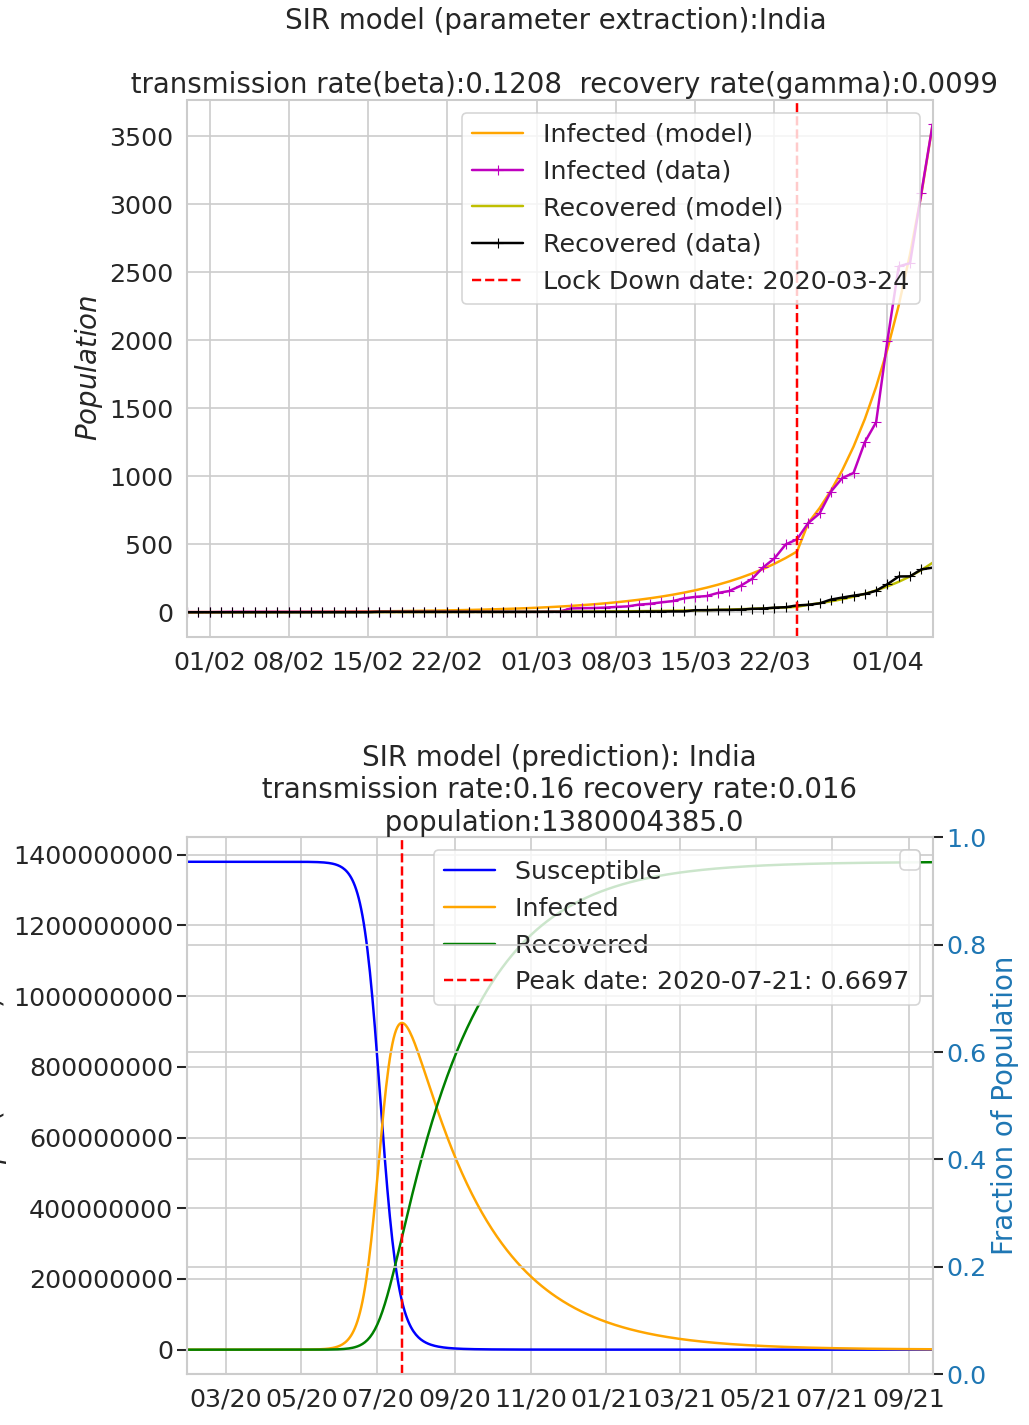

interactive(children=(Dropdown(description='COUNTRY', index=72, options=('Afghanistan', 'Albania', 'Algeria', …

In [127]:
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import warnings
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np


%matplotlib nbagg
warnings.filterwarnings("ignore",category=UserWarning)
%matplotlib nbagg
import numpy as np

# #fig, ax1 = plt.subplots(1, figsize=(15, 9))
# # fig, ax = plt.subplots(1, figsize=(15, 9),frameon=False)
fig, (ax1, ax) = plt.subplots( 2,figsize=(13, 18))
plt.subplots_adjust( hspace=0.5, wspace=0.7)

ax2 = ax.twinx()

plt.subplots_adjust( hspace=0.6, wspace=0.5)

def save_plot1(country,gamma_change,beta_change,ldate):
    N=600
    if country in ld_dict.keys():
        
        beta_b,gamma_b,p,N_T0,I1,R1=get_parameters_before_ld(country,pd.to_datetime(ld_dict[country]))
        beta_a,gamma_a,p,N_T1,I2,R2=get_parameters_after_ld(country,pd.to_datetime(ld_dict[country]))
        S_b, I_b, R_b = simulate_sir_model_b(beta_b, gamma_b, len(I1), p, I1)
        
        S_a, I_a, R_a = simulate_sir_model_a(beta_a, gamma_a, len(I2), p, I2,R2)

        I1.extend(I2)
        R1.extend(R2)
        I_b.extend(I_a)
        R_b.extend(R_a)
        S_b.extend(S_a)
        S_a_0=S_b.copy()
        I_a_0=I_b.copy()
        R_a_0=R_b.copy()
        
        d =(pd.to_datetime(ldate)-pd.to_datetime('2020-04-05')).days
        print(d)
        if d!=0:
            S_a_2, I_a_2, R_a_2 = simulate_sir_model_a(beta_a, gamma_a, d, p, [I_a[-1]],[R_a[-1]])
            S_a_0.extend(S_a_2)
            I_a_0.extend(I_a_2)
            R_a_0.extend(R_a_2)
            S_a_1, I_a_1, R_a_1 = simulate_sir_model_a(beta_change, gamma_change, N-len(S_a_0), p, [I_a_2[-1]],[R_a_2[-1]])
        else:
            S_a_1, I_a_1, R_a_1 = simulate_sir_model_a(beta_change, gamma_change, N-len(S_a_0), p, [I_a[-1]],[R_a[-1]])
       
        
        
        
        S_a_0.extend(S_a_1)
        I_a_0.extend(I_a_1)
        R_a_0.extend(R_a_1)
    else:
        beta_b,gamma_b,p,N_T0,I1,R1=get_parameters_before_ld(country,pd.to_datetime('2020-04-05'))
        S_b, I_b, R_b = simulate_sir_model_b(beta_b, gamma_b, len(I1), p, I1)
        
        S_a_0=S_b.copy()
        I_a_0=I_b.copy()
        R_a_0=R_b.copy()
        d =(pd.to_datetime(ldate)-pd.to_datetime('2020-04-05')).days
        print(d)
        if d!=0:
            S_a_2, I_a_2, R_a_2 = simulate_sir_model_a(beta_b, gamma_b, d, p, [I_b[-1]],[R_b[-1]])
            S_a_0.extend(S_a_2)
            I_a_0.extend(I_a_2)
            R_a_0.extend(R_a_2)
            S_a_1, I_a_1, R_a_1 = simulate_sir_model_a(beta_change, gamma_change, N-len(S_a_0), p, [I_a_2[-1]],[R_a_2[-1]])
        else:
            S_a_1, I_a_1, R_a_1 = simulate_sir_model_a(beta_change, gamma_change, N-len(S_a_0), p, [I_b[-1]],[R_b[-1]])
       
        S_a_0.extend(S_a_1)
        I_a_0.extend(I_a_1)
        R_a_0.extend(R_a_1)
    

    ax1.clear() 
    # (2) plot for data
    #fig, ax1 = plt.subplots(figsize=(12, 10))

    dates = [(N_T0 + i*pd.Timedelta("24h")).date() for i in range(len(I1))]
    n = len(dates)
    
    
    model_data = pd.DataFrame(index=dates)
    fit_styles = ["orange", "m+-", "y-", "k+-"]
    model_data.loc[:, "Infected (model)"] = I_b[:n]
    model_data.loc[:, "Infected (data)"] = I1[:n]
    
    model_data.loc[:, "Recovered (model)"] = R_b[:n]
    model_data.loc[:, "Recovered (data)"] = R1[:n]
    model_data.plot(ax=ax1, style=fit_styles)
    ax1.set_title("SIR model (parameter extraction):{} \n\n transmission rate(beta):{}  recovery rate(gamma):{}".format(country,np.round(beta_b,4),np.round(gamma_b,4)))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    #ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x) + 'K'))
    ax1.set_ylabel('$Population $')
    
    if country in ld_dict.keys():
        
        ax1.axvline(ld_dict[country], color="r", ls="--", label=f"Lock Down date: {ld_dict[country]}")
    ax1.legend(loc=1)
    
    #plt.legend()
    
    ax2.clear()
    ax.clear()
    styles = ['b','orange','g','b','orange','g']
    
    # (1) plot for model
    #fig, ax = plt.subplots(figsize=(15, 10))
    dates = [(N_T0 + i*pd.Timedelta("24h")).date() for i in range(N)]
    model_data = pd.DataFrame(index=dates)

    model_data.loc[:, "Susceptible "] = S_a_0
    model_data.loc[:, "Infected "] = I_a_0
    model_data.loc[:, "Recovered "] = R_a_0
    model_data.plot(ax=ax, style=styles)
    plt.title("\n\nSIR model (prediction): {}\n transmission rate:{} recovery rate:{} \n population:{}".format(country,np.round(beta_change,4),np.round(gamma_change,4),p))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
    #ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{}'.format(x/1e6) + 'M' ))
    
    ax.get_yaxis().get_major_formatter().set_scientific(False)
      # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Fraction of Population', color=color)  # we already handled the x-label with ax1
    #ax2.plot(t, data2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    
    ax.set_ylabel('$People (Millions)$')
    # peak 
    #peak_date1 = np.argmax(I_b_0)
    peak_date2 = np.argmax(I_a_0)
    
 
   #ax.axvline(dates[peak_date1], color="r", ls="--", label=f"Peak date w/0 LD: {dates[peak_date1]}")
    ax.axvline(dates[peak_date2], color="r", ls="--", label=f"Peak date: {dates[peak_date2]}: {np.round(I_a_0[peak_date2]/p,4)}")
    ax.legend(loc=1)
    #plt.savefig('test_plot/{}.png'.format(country))

    plt.legend()
    plt.show()
    
country=widgets.Dropdown(
    options=covid_df_full.Country.unique(),
    value='India',
    description='COUNTRY',
    disabled=False,
)
ldate=widgets.Dropdown(
    options=['2020-04-05','2020-04-07','2020-04-30','2020-05-01'],
    value='2020-04-05',
    description='POLICY',
    disabled=False,
)
gamma_change = widgets.FloatSlider(min=0, max=1,step=0.001, value=0.016, description='recovery rate(gamma)')
beta_change = widgets.FloatSlider(min=0, max=1,step=0.001, value=0.16, description='transmission rate(beta):')


def update_x_range(*args):
    #print(country.value)
    if country.value in ld_dict.keys():

        beta_a,gamma_a,p,N_T1,I2,R2=get_parameters_after_ld(country.value,pd.to_datetime(ld_dict[country.value]))
    
    else:
         
        beta_a,gamma_a,p,N_T0,I1,R1=get_parameters_before_ld(country.value,pd.to_datetime('2020-04-05'))
        #print("dd")
    gamma_change.value=gamma_a
    
    beta_change.value=beta_a
    
    
   
country.observe(update_x_range, 'value')

widgets.interactive(save_plot1,country=country, gamma_change=gamma_change, beta_change=beta_change,ldate=ldate)


In [ ]:
0.02,0.08
40 9-23

In [ ]:
37%  

In [ ]:
40% 9-12

In [63]:
from ipywidgets.embed import embed_minimal_html


embed_minimal_html('export1.html', views=[country, gamma_change, beta_change,ldate], title='Widgets export')

In [84]:
1000/1e6

0.001

In [26]:
from datetime import date
date('2020-04-05')

TypeError: an integer is required (got type str)

In [37]:
(pd.to_datetime('2020-04-05')-pd.to_datetime('2020-04-03')).days

2

In [ ]:

d0 = date(2008, 8, 18)
d1 = date(2008, 9, 26)
delta = d1 - d0
print(delta.days)

# Another method 
https://towardsdatascience.com/modelling-the-coronavirus-epidemic-spreading-in-a-city-with-python-babd14d82fa2

In [36]:
import numpy as np
# initialize the population vector from the origin-destination flow matrix
N_k = np.abs(np.diagonal(OD) + OD.sum(axis=0) - OD.sum(axis=1))
locs_len = len(N_k)                 # number of locations
SIR = np.zeros(shape=(locs_len, 3)) # make a numpy array with 3 columns for keeping track of the S, I, R groups
SIR[:,0] = N_k                      # initialize the S group with the respective populations

first_infections = np.where(SIR[:, 0]<=thresh, SIR[:, 0]//20, 0)   # for demo purposes, randomly introduce infections
SIR[:, 0] = SIR[:, 0] - first_infections
SIR[:, 1] = SIR[:, 1] + first_infections                           # move infections to the I group

# row normalize the SIR matrix for keeping track of group proportions
row_sums = SIR.sum(axis=1)
SIR_n = SIR / row_sums[:, np.newaxis]

# initialize parameters
beta = 1.6
gamma = 0.04
public_trans = 0.5                                 # alpha
R0 = beta/gamma
beta_vec = np.random.gamma(1.6, 2, locs_len)
gamma_vec = np.full(locs_len, gamma)
public_trans_vec = np.full(locs_len, public_trans)

# make copy of the SIR matrices 
SIR_sim = SIR.copy()
SIR_nsim = SIR_n.copy()

# run model
print(SIR_sim.sum(axis=0).sum() == N_k.sum())
from tqdm import tqdm_notebook
infected_pop_norm = []
susceptible_pop_norm = []
recovered_pop_norm = []
for time_step in tqdm_notebook(range(100)):
  infected_mat = np.array([SIR_nsim[:,1],]*locs_len).transpose()
  OD_infected = np.round(OD*infected_mat)
  inflow_infected = OD_infected.sum(axis=0)
  inflow_infected = np.round(inflow_infected*public_trans_vec)
  print('total infected inflow: ', inflow_infected.sum())
  new_infect = beta_vec*SIR_sim[:, 0]*inflow_infected/(N_k + OD.sum(axis=0))
  new_recovered = gamma_vec*SIR_sim[:, 1]
  new_infect = np.where(new_infect>SIR_sim[:, 0], SIR_sim[:, 0], new_infect)
  SIR_sim[:, 0] = SIR_sim[:, 0] - new_infect
  SIR_sim[:, 1] = SIR_sim[:, 1] + new_infect - new_recovered
  SIR_sim[:, 2] = SIR_sim[:, 2] + new_recovered
  SIR_sim = np.where(SIR_sim<0,0,SIR_sim)
  # recompute the normalized SIR matrix
  row_sums = SIR_sim.sum(axis=1)
  SIR_nsim = SIR_sim / row_sums[:, np.newaxis]
  S = SIR_sim[:,0].sum()/N_k.sum()
  I = SIR_sim[:,1].sum()/N_k.sum()
  R = SIR_sim[:,2].sum()/N_k.sum()
  print(S, I, R, (S+I+R)*N_k.sum(), N_k.sum())
  print('\n')
  infected_pop_norm.append(I)
  susceptible_pop_norm.append(S)
  recovered_pop_norm.append(R)

NameError: name 'OD' is not defined